In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib.path as mpath
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import numpy as np
import pandas as pd
import cmocean
import utm

In [2]:
def draw_SOcustom(X,Y,Z,cmap,cbar_label,title,plot_type,**kwargs):
    
    crs_plot = ccrs.SouthPolarStereo()
    crs_source = ccrs.PlateCarree()
    
    fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
    ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    ax.set_title(title,fontsize=14,pad = 20)
    
    if plot_type == 'contourf':
        im = ax.contourf(X,Y,Z,kwargs['clevs'],cmap=cmap,transform=crs_source)
    elif plot_type == 'pcolormesh':
        im = ax.pcolormesh(X,Y,Z,cmap=cmap,transform=crs_source,vmin=kwargs['clims'][0],vmax=kwargs['clims'][1])
    
    cbar = plt.colorbar(im,orientation='horizontal',fraction=0.025,pad=0.05)
    cbar.set_label(cbar_label,fontsize=12)
    
#     plt.show()
    
    return fig,ax

In [3]:
def draw_globalcustom(X,Y,Z,cmap,cbar_label,title,plot_type,**kwargs):
    
    crs_plot = ccrs.Robinson()
    crs_source = ccrs.PlateCarree()
    
    fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
    ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, 90], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    ax.set_title(title,fontsize=14,pad = 20)
    
    if plot_type == 'contourf':
        im = ax.contourf(X,Y,Z,kwargs['clevs'],cmap=cmap,transform=crs_source)
    elif plot_type == 'pcolormesh':
        im = ax.pcolormesh(X,Y,Z,cmap=cmap,transform=crs_source,vmin=kwargs['clims'][0],vmax=kwargs['clims'][1])
    
    cbar = plt.colorbar(im,orientation='horizontal',fraction=0.025,pad=0.05)
    cbar.set_label(cbar_label,fontsize=12)
    
#     plt.show()
    
    return fig,ax

## Plots for Southern Ocean dynamics lectures

### Load and calculate variables

In [4]:
time_bnds = [360,480]

#### Wind stress

In [5]:
rootdir = '/local/data/era-interim/'
dx = xr.open_dataset(rootdir+'griddx.nc')
dy = xr.open_dataset(rootdir+'griddy.nc')
grid_era = xr.merge([dx,dy])
grid_era = grid_era.where(grid_era.latitude<=-30,drop=True)
wind = xr.open_dataset(rootdir+'erai_wind10_monthly_197901-201812.nc').isel(time=slice(time_bnds[0],time_bnds[1]))
wind = wind.where(wind.latitude<=-30,drop=True)

In [6]:
cd_u = (2.7/wind['u10']+0.142+0.076*wind['u10'])/1000 # Large and Yeager (2004)
cd_v = (2.7/wind['v10']+0.142+0.076*wind['v10'])/1000 # Large and Yeager (2004)
# cd = (0.8+0.065*wind['u10'])/1000 # Wu (1982)
rho = 1.22
# Wind stress
taux = rho*cd_u*wind['u10']**2
tauy = rho*cd_v*wind['v10']**2
taux_now = taux.mean('time')
tauy_now = tauy.mean('time')
# Wind stress curl
dtdy_now = (taux_now.sortby('latitude').diff(dim='latitude')/grid_era['dy']).sortby('latitude',ascending=False)
dtdx_now = (tauy_now-tauy_now.roll({'longitude':1},roll_coords=False))/grid_era['dx']
dt_now = dtdy_now-dtdx_now

#### Buoyancy fluxes

In [7]:
rootdir = '/local/projects/so_decadal_variability/'
grid_name = 'en4'
ocean_name = 'en4'
flux_name = 'erai'
ocean_times = '197901-201812'
flux_times = '1979-2018'
# Grid
dx = xr.open_dataset(rootdir+'grid/SO_grid_dx_'+grid_name+'.nc')
dy = xr.open_dataset(rootdir+'grid/SO_grid_dy_'+grid_name+'.nc')
grid_en4 = xr.merge([dx,dy])
# Hydrography
ct = xr.open_dataset(rootdir+'ocean/SO_ocean_ct_'+ocean_name+'_'+ocean_times+'.nc').isel(time=slice(time_bnds[0],time_bnds[1]))
sa = xr.open_dataset(rootdir+'ocean/SO_ocean_sa_'+ocean_name+'_'+ocean_times+'.nc').isel(time=slice(time_bnds[0],time_bnds[1]))
gamman = xr.open_dataset(rootdir+'ocean/SO_ocean_gamman_'+ocean_name+'_'+ocean_times+'.nc').isel(time=slice(time_bnds[0],time_bnds[1]))
alpha = xr.open_dataset(rootdir+'ocean/SO_ocean_alpha_'+ocean_name+'_'+ocean_times+'.nc').isel(time=slice(time_bnds[0],time_bnds[1]))
beta = xr.open_dataset(rootdir+'ocean/SO_ocean_beta_'+ocean_name+'_'+ocean_times+'.nc').isel(time=slice(time_bnds[0],time_bnds[1]))
rho = xr.open_dataset(rootdir+'ocean/SO_ocean_rho_'+ocean_name+'_'+ocean_times+'.nc').isel(time=slice(time_bnds[0],time_bnds[1]))
# Merge
ocean = xr.merge([ct,sa,gamman,alpha,beta,rho])
# Heat and freshwater flux
Q = xr.open_dataset(rootdir+'flux/SO_flux_ht_'+flux_name+'_'+grid_name+'_'+flux_times+'.nc').isel(time=slice(time_bnds[0],time_bnds[1])).assign_coords(time=ocean.time)
Qsw = xr.open_dataset(rootdir+'flux/SO_flux_sr_'+flux_name+'_'+grid_name+'_'+flux_times+'.nc').isel(time=slice(time_bnds[0],time_bnds[1])).assign_coords(time=ocean.time)
FW = -xr.open_dataset(rootdir+'flux/SO_flux_fw_'+flux_name+'_'+grid_name+'_'+flux_times+'.nc').isel(time=slice(time_bnds[0],time_bnds[1])).assign_coords(time=ocean.time)

In [16]:
x = beta['beta'].isel(time=0,depth=0)
xbar = (x*grid_en4['dx']*grid_en4['dx']).sum(['lon','lat'])/(grid_en4['dx']*grid_en4['dx']).sum(['lon','lat'])
print(xbar)

<xarray.DataArray ()>
array(0.00069065, dtype=float32)
Coordinates:
    time     datetime64[ns] 2009-01-16T12:00:00
    depth    float32 5.0215898


In [7]:
def calc_F(FW,Q,Qsw,S,alpha,beta,Cp=4200):
    
    Fheat = (alpha/Cp)*Q + (alpha/Cp)*Qsw
    Ffw = -FW*S*beta
    F = Fheat+Ffw
    
    F.name = 'F'
    Fheat.name = 'Fheat'
    Ffw.name = 'Ffw'
    
    return F, Fheat, Ffw

In [8]:
# Calculate density flux
F,Fheat,Ffw = calc_F(FW.fw,Q.ht,Qsw.sr,ocean.sa.isel(depth=0),ocean.alpha.isel(depth=0),ocean.beta.isel(depth=0))
Fheat_now = Fheat.mean('time')
Ffw_now = Ffw.mean('time')
F_now = F.mean('time')

/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


#### Sea ice concentration

In [9]:
rootdir = '/home/aos/graemem/data/'
ds_sic = xr.open_dataset(rootdir+'erai_siconc_monthly_2009-2018.nc')
ds_sic = ds_sic.assign_coords(time=pd.to_datetime(ds_sic.time.values).month)
ds_sic_clim = ds_sic.groupby('time').mean().where(ds_sic['latitude']<=-30,drop=True)

/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


#### Bathymetry

In [61]:
rootdir = '/local/data/'
ext = 'gebco/GEBCO_2019_17_Feb_2020_1438586bc08e/'
gebco = xr.open_mfdataset(rootdir+ext+'gebco_2019_n-30.0_s-80.0_w*.nc',combine='by_coords')
gebco = gebco.coarsen(lon=100,lat=100).mean()
# Calculate gradients of topography
dhdx = gebco['elevation'].differentiate('lon')
dhdy = gebco['elevation'].differentiate('lat')
gradh = np.sqrt(dhdx**2+dhdy**2)

#### zonal wind stress

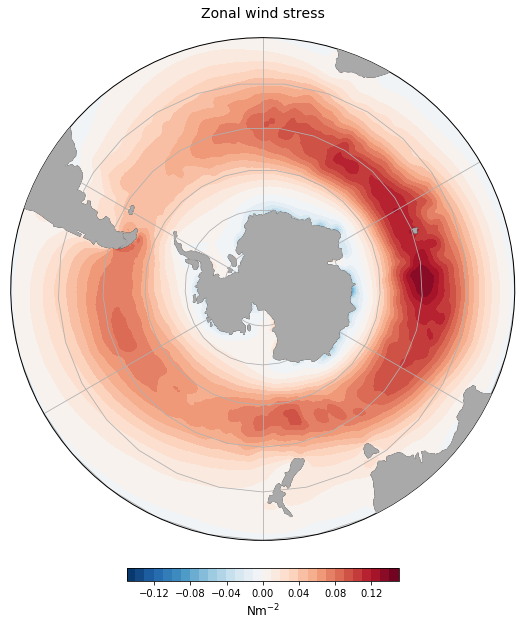

In [10]:
lat = taux_now['latitude']
lon = taux_now['longitude']
taux,lon = add_cyclic_point(taux_now.values,lon.values)

fig,ax = draw_SOcustom(lon.data,lat.values,taux.data,
                        cmap='RdBu_r',cbar_label='Nm$^{-2}$',
                      title = 'Zonal wind stress', plot_type='contourf',clevs=np.arange(-0.15,0.16,0.01))

#### meridional windstress

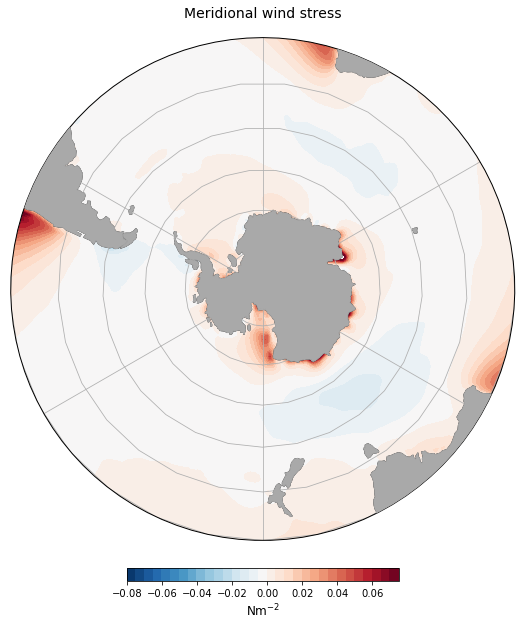

In [102]:
lat = tauy_now['latitude']
lon = tauy_now['longitude']
tauy,lon = add_cyclic_point(tauy_now.values,lon.values)

fig,ax = draw_SOcustom(lon.data,lat.values,tauy.data,
                        cmap='RdBu_r',cbar_label='Nm$^{-2}$',
                      title = 'Meridional wind stress', plot_type='contourf',clevs=np.arange(-0.08,0.08,0.005))

#### wind stress curl

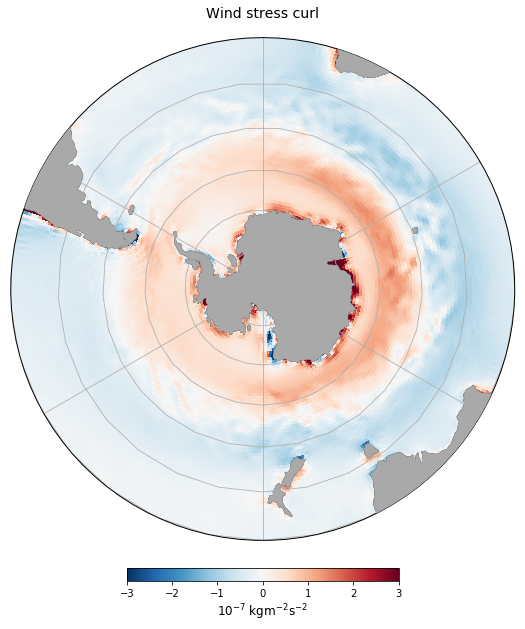

In [97]:
lat = tauy_now['latitude']
lon = tauy_now['longitude']
dt,lon = add_cyclic_point(dt_now.values,lon.values)

fig,ax = draw_SOcustom(lon.data,lat.values,1E7*dt.data,
                        cmap='RdBu_r',cbar_label='10$^{-7}$ kgm$^{-2}$s$^{-2}$',
                      title = 'Wind stress curl', plot_type='pcolormesh',clims=[-3,3])

#### surface heat flux (units of buoyancy flux)

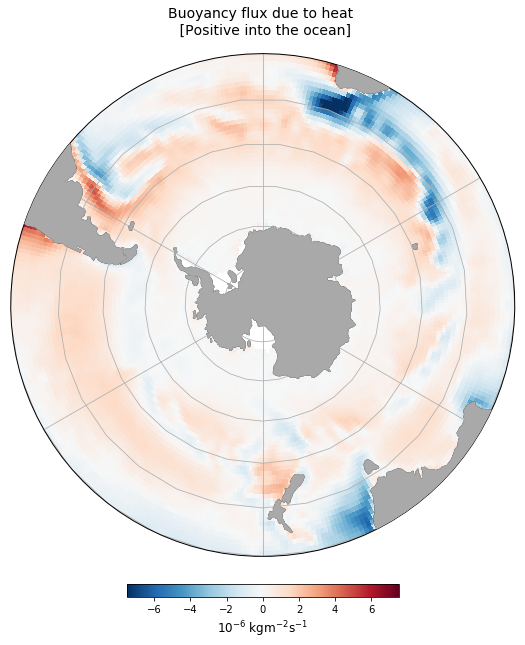

In [136]:
lat = Fheat_now['lat']
lon = Fheat_now['lon']
Fheat,lon = add_cyclic_point(Fheat_now.values,lon.values)

fig,ax = draw_SOcustom(lon.data,lat.values,1E6*Fheat.data,
                        cmap='RdBu_r',clims=[-7.5,7.5],cbar_label='$10^{-6}$ kgm$^{-2}$s$^{-1}$',
                      title = 'Buoyancy flux due to heat \n [Positive into the ocean]')

#### surface water flux (units of buoyancy flux)

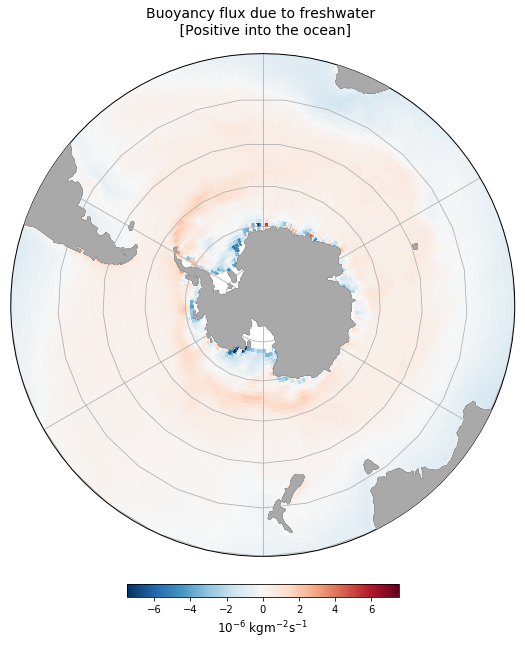

In [137]:
lat = Ffw_now['lat']
lon = Ffw_now['lon']
Ffw,lon = add_cyclic_point(Ffw_now.values,lon.values)

fig,ax = draw_SOcustom(lon.data,lat.values,1E6*Ffw.data,
                        cmap='RdBu_r',clims=[-7.5,7.5],cbar_label='$10^{-6}$ kgm$^{-2}$s$^{-1}$',
                      title = 'Buoyancy flux due to freshwater \n [Positive into the ocean]')

#### net buoyancy flux (including lines of max/min sea-ice extent)

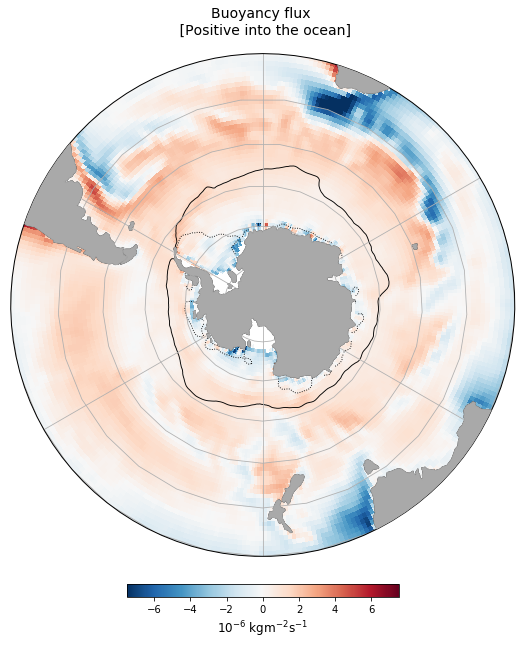

In [41]:
lat = F_now['lat']
lon = F_now['lon']
F,lon = add_cyclic_point(F_now.values,lon.values)

fig,ax = draw_SOcustom(lon.data,lat.values,1E6*F.data,
                        cmap='RdBu_r',clims=[-7.5,7.5],cbar_label='$10^{-6}$ kgm$^{-2}$s$^{-1}$',
                      title = 'Buoyancy flux \n [Positive into the ocean]',plot_type='pcolormesh')

lat = ds_sic_clim['latitude']
lon = ds_sic_clim['longitude']
c,lon = add_cyclic_point(ds_sic_clim['siconc'].isel(time=9).values,lon.values)
ax.contour(lon.data,lat.values,c.data,[0.25],colors='k',linestyles='-',linewidths=0.9,transform=ccrs.PlateCarree())

lat = ds_sic_clim['latitude']
lon = ds_sic_clim['longitude']
c,lon = add_cyclic_point(ds_sic_clim['siconc'].isel(time=1).values,lon.values)
ax.contour(lon.data,lat.values,c.data,[0.25],colors='k',linestyles=':',linewidths=0.9,transform=ccrs.PlateCarree())

#### bottom topography

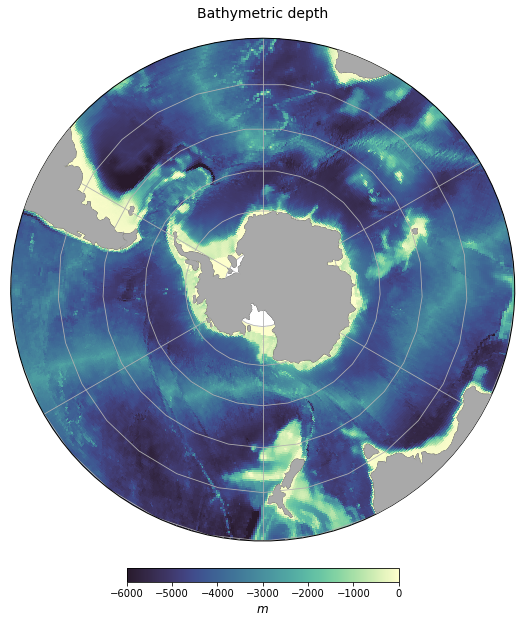

In [63]:
lat = gebco['lat']
lon = gebco['lon']
h,lon = add_cyclic_point(gebco['elevation'].values,lon.values)

fig,ax = draw_SOcustom(lon.data,lat.values,h,
                        cmap=cmocean.cm.deep_r,clims=[-6000,0],cbar_label='$m$',
                      title = 'Bathymetric depth',plot_type='pcolormesh')

#### | grad H |

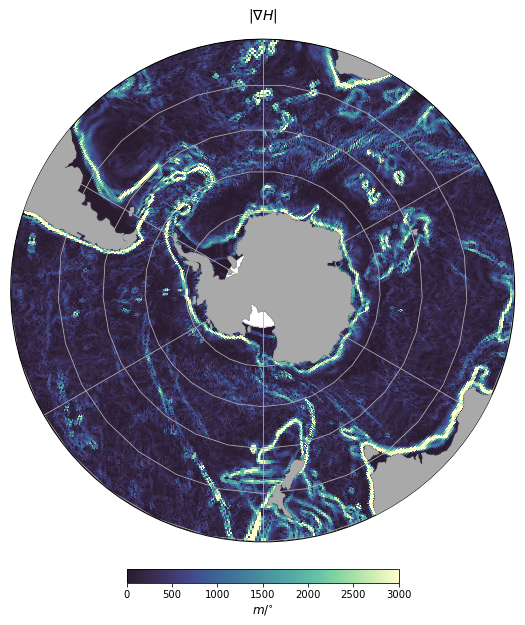

In [69]:
lat = gebco['lat']
lon = gebco['lon']
dh,lon = add_cyclic_point(gradh.values,lon.values)

fig,ax = draw_SOcustom(lon.data,lat.values,dh,
                        cmap=cmocean.cm.deep_r,clims=[0,3000],cbar_label=r'$m/^{\circ}$',
                      title = r'$|\nabla H|$',plot_type='pcolormesh')